<a href="https://colab.research.google.com/github/Mjapo/AplicandoTransferLearning/blob/main/notebooks/transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

This tutorial will guide you through the process of using _transfer learning_ to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

#### Feature extraction vs. fine-tuning

At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

Sometimes, we do something in-between: Freeze just the early/generic layers, but fine-tune the later layers. Which strategy is best depends on the size of your dataset, the number of classes, and how much it resembles the dataset the previous model was trained on (and thus, whether it can benefit from the same learned feature extractors). A more detailed discussion of how to strategize can be found in [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer-learning/).

## Procedure

In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) which [won the ImageNet challenge in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of around 6000 images belonging to 97 classes, and train an image classifier with around 80% accuracy on it. It's worth noting that this strategy scales well to image sets where you may have even just a couple hundred or less images. Its performance will be lesser from a small number of samples (depending on classes) as usual, but still impressive considering the usual constraints.


In [10]:
pip install tensorflow-datasets


In [11]:
%matplotlib inline
import os
import zipfile
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [23]:
import tensorflow_datasets as tfds
import os

# Diretório para salvar o conjunto de dados
data_dir = 'tmp/'

# Certifique-se de que o diretório existe
os.makedirs(data_dir, exist_ok=True)

# Baixa e carrega o conjunto de dados CIFAR-10
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, data_dir=data_dir)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling tmp/cifar10/3.0.2.incomplete30D7DR/cifar10-train.tfrecord*...:   0%|          | 0/50000 [00:00<?, ? …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling tmp/cifar10/3.0.2.incomplete30D7DR/cifar10-test.tfrecord*...:   0%|          | 0/10000 [00:00<?, ? e…

Dataset cifar10 downloaded and prepared to tmp/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpphphyq1btfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHRE

In [12]:
import tensorflow as tf


In [28]:
# Diretório para salvar o conjunto de dados
data_dir = '/tmp/'

# Certifique-se de que o diretório existe
import os
os.makedirs(data_dir, exist_ok=True)

# Baixa e carrega o conjunto de dados CIFAR-10
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, data_dir=data_dir)

# Pré-processamento dos dados
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normaliza os pixels para o intervalo [0, 1]
    return image, label

# Aplica o pré-processamento aos dados de treinamento e teste
train_dataset = dataset['train'].map(preprocess_image)
test_dataset = dataset['test'].map(preprocess_image)


In [13]:
import tensorflow_datasets as tfds
import tensorflow as tf

This function is useful for pre-processing the data into an image and input vector.

In [14]:
# Pré-processamento dos dados
def preprocess_image(image, label):
    # Redimensiona a imagem para o tamanho esperado
    image = tf.image.resize(image, (32, 32))
    # Normaliza os pixels para o intervalo [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Baixa e carrega o conjunto de dados CIFAR-10
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True)

# Aplica o pré-processamento aos dados de treinamento e teste e agrupa em lotes
train_dataset = dataset['train'].map(preprocess_image).shuffle(50000).batch(32)
test_dataset = dataset['test'].map(preprocess_image).batch(32)


Load all the images from root folder

In [15]:
# Define o modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

Randomize the data order.

In [16]:
# Compila o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Treina o modelo
model.fit(train_dataset, epochs=10)


Epoch 1/10
1563/1563 [==============================] - 21s 5ms/step - loss: 1.5330 - accuracy: 0.4407
Epoch 2/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.1725 - accuracy: 0.5837
Epoch 3/10
1563/1563 [==============================] - 9s 4ms/step - loss: 1.0395 - accuracy: 0.6332
Epoch 4/10
1563/1563 [==============================] - 10s 5ms/step - loss: 0.9518 - accuracy: 0.6661
Epoch 5/10
1563/1563 [==============================] - 16s 7ms/step - loss: 0.8789 - accuracy: 0.6925
Epoch 6/10
1563/1563 [==============================] - 9s 4ms/step - loss: 0.8222 - accuracy: 0.7117
Epoch 7/10
1563/1563 [==============================] - 12s 6ms/step - loss: 0.7737 - accuracy: 0.7293
Epoch 8/10
1563/1563 [==============================] - 10s 5ms/step - loss: 0.7249 - accuracy: 0.7445
Epoch 9/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.6838 - accuracy: 0.7586
Epoch 10/10
1563/1563 [==============================] - 10s 5ms/step - loss:

create training / validation / test split (70%, 15%, 15%)

In [18]:
# Avalia o modelo
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Acurácia do teste: {test_acc}')

313/313 [==============================] - 2s 6ms/step - loss: 0.9228 - accuracy: 0.6987
Acurácia do teste: 0.6987000107765198


Separate data for labels.

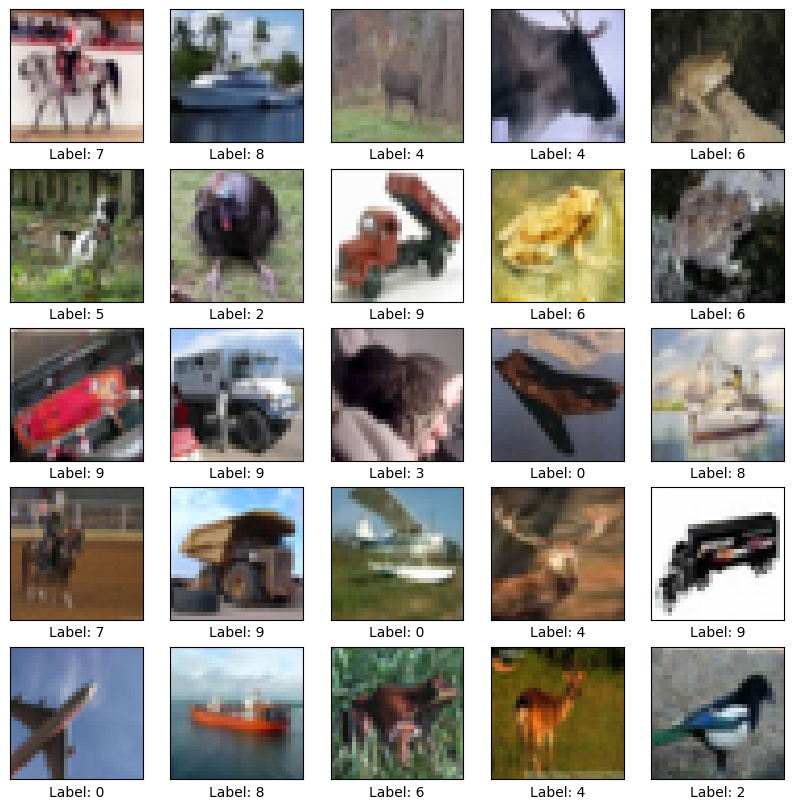

In [23]:
import matplotlib.pyplot as plt

# Função para exibir uma grade de imagens
def show_images(dataset, num_images=25):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image.numpy())
        plt.xlabel(f'Label: {label.numpy()}')
    plt.show()

# Exibe algumas imagens do conjunto de treinamento
show_images(dataset['train'])


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [24]:
# Normaliza os dados
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

# Converte labels para one-hot vectors
def one_hot_label(image, label):
    label = tf.one_hot(label, depth=10)
    return image, label

train_dataset = train_dataset.map(one_hot_label)
test_dataset = test_dataset.map(one_hot_label)

# Define os tamanhos de lote e embaralha os dados
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(50000)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Divisão entre treino e validação
val_size = info.splits['train'].num_examples // 10
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)


Let's get a summary of what we have.

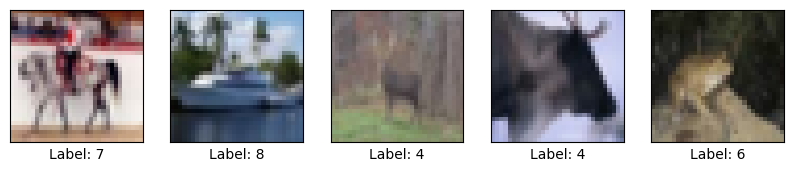

In [25]:
import matplotlib.pyplot as plt

# Função para exibir uma grade de imagens
def show_images(dataset, num_images=5):
    plt.figure(figsize=(10,10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image.numpy())
        plt.xlabel(f'Label: {label.numpy()}')
    plt.show()

# Exibe algumas imagens do conjunto de treinamento
show_images(dataset['train'])


If everything worked properly, you should have loaded a bunch of images, and split them into three sets: `train`, `val`, and `test`. The shape of the training data should be (`n`, 224, 224, 3) where `n` is the size of your training set, and the labels should be (`n`, `c`) where `c` is the number of classes (97 in the case of `101_ObjectCategories`.

Notice that we divided all the data into three subsets -- a training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

Let's quickly look at a few sample images from our dataset.

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

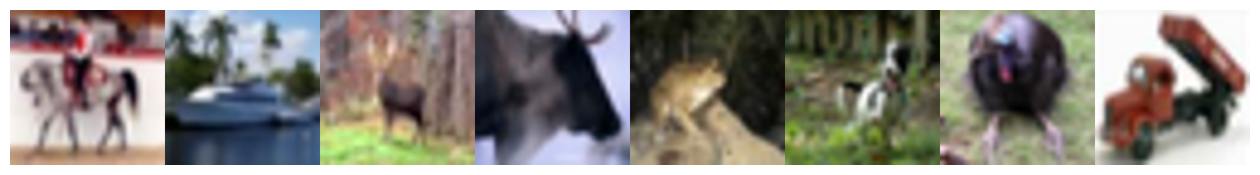

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Carrega o conjunto de dados CIFAR-10
(train_data, test_data), info = tfds.load('cifar10', split=['train', 'test'], with_info=True)

# Seleciona aleatoriamente 8 índices de imagens
idx = [int(info.splits['train'].num_examples * tf.random.uniform([], seed=1)) for _ in range(8)]

# Converte o conjunto de dados de treinamento em um iterador numpy
train_data_iter = iter(tfds.as_numpy(train_data))

# Carrega as imagens selecionadas e as redimensiona para 224x224 pixels
imgs = [image.array_to_img(next(train_data_iter)['image']).resize((224, 224)) for _ in range(8)]

# Converte as imagens em tensores e as normaliza
imgs = [tf.cast(image.img_to_array(img) / 255.0, tf.float32) for img in imgs]

# Concatena as imagens em uma única imagem
concat_image = tf.concat(imgs, axis=1)

# Exibe a imagem concatenada
plt.figure(figsize=(16, 4))
plt.imshow(concat_image)
plt.axis('off')
plt.show()


We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

# Número de classes no conjunto de dados CIFAR-10
num_classes = 10

# Cria o modelo Sequential
model = Sequential()

# Adiciona a primeira camada convolucional
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adiciona a segunda camada convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adiciona uma camada de dropout para regularização
model.add(Dropout(0.25))

# Adiciona a terceira camada convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adiciona uma camada de dropout para regularização
model.add(Dropout(0.25))

# Transforma os mapas de características em um vetor unidimensional
model.add(Flatten())

# Adiciona uma camada densa com 256 unidades
model.add(Dense(256))
model.add(Activation('relu'))

# Adiciona uma camada de dropout para regularização
model.add(Dropout(0.5))

# Adiciona a camada de saída com ativação softmax para classificação das 10 classes
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Exibe o resumo do modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 13, 13, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                 

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

# Número de classes no conjunto de dados CIFAR-10
num_classes = 10

# Cria o modelo Sequential
model = Sequential()

# Adiciona a primeira camada convolucional
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adiciona a segunda camada convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adiciona uma camada de dropout para regularização
model.add(Dropout(0.25))

# Adiciona a terceira camada convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adiciona uma camada de dropout para regularização
model.add(Dropout(0.25))

# Transforma os mapas de características em um vetor unidimensional
model.add(Flatten())

# Adiciona uma camada densa com 256 unidades
model.add(Dense(256))
model.add(Activation('relu'))

# Adiciona uma camada de dropout para regularização
model.add(Dropout(0.5))

# Adiciona a camada de saída com ativação softmax para classificação das 10 classes
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Exibe o resumo do modelo
model.summary()

# Compila o modelo
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=[Accuracy()])

# Treina o modelo
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 activation_5 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 13, 13, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                 

NameError: name 'x_train' is not defined

Let's plot the validation loss and validation accuracy over time.

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 1.5231 - accuracy: 0.4444 - val_loss: 1.2822 - val_accuracy: 0.5421
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1664 - accuracy: 0.5849 - val_loss: 1.0583 - val_accuracy: 0.6202
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0082 - accuracy: 0.6445 - val_loss: 1.0193 - val_accuracy: 0.6378
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9118 - accuracy: 0.6796 - val_loss: 0.9545 - val_accuracy: 0.6661
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8365 - accuracy: 0.7052 - val_loss: 0.8982 - val_accuracy: 0.6877
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7774 - accuracy: 0.7259 - val_loss: 0.8979 - val_accuracy: 0.6879
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7223 - accuracy: 0.7459 - val_loss: 0.9022 - val_accuracy

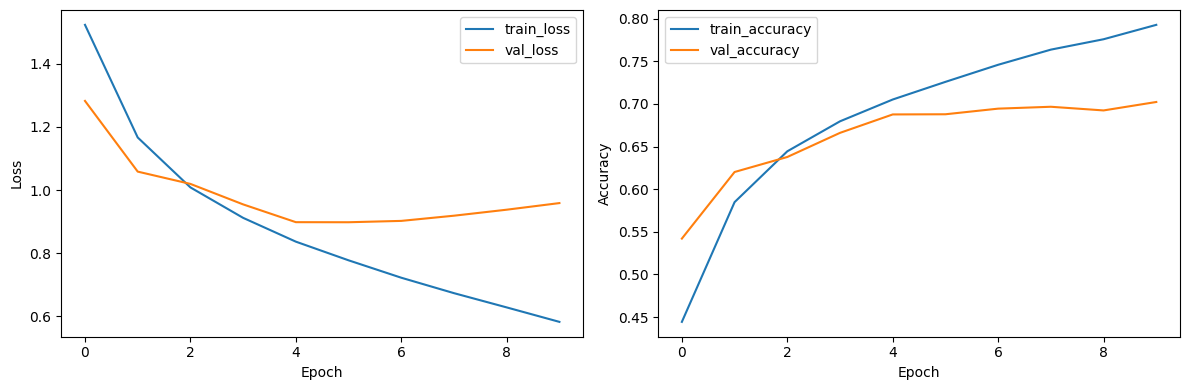

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Carregando e pré-processando os dados
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Construindo o modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compilando o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinando o modelo
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_test, y_test))

# Plotando os resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



Notice that the validation loss begins to actually rise after around 16 epochs, even though validation accuracy remains roughly between 40% and 50%. This suggests our model begins overfitting around then, and best performance would have been achieved if we had stopped early around then. Nevertheless, our accuracy would not have likely been above 50%, and probably lower down.

We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [30]:
# Avaliando o modelo nos dados de teste
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Test loss: 0.9586113095283508
Test accuracy: 0.7023000121116638


Finally, we see that we have achieved a (top-1) accuracy of around 49%. That's not too bad for 6000 images, considering that if we were to use a naive strategy of taking random guesses, we would have only gotten around 1% accuracy.

## Transfer learning by starting with existing network

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the `summary()` method.

In [31]:
from tensorflow.keras.applications import VGG16

# Carrega a VGG16 com pesos do ImageNet e inclui a camada fully connected no topo
vgg = VGG16(weights='imagenet', include_top=True)

# Exibe um resumo da rede
vgg.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 97 neurons in the case of the 101_ObjectCategories dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [32]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset.

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of CalTech-101, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [73]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 97-neuron softmax. Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 397,000 trainable parameters, which is actually only a quarter of the number of parameters needed to train the first model.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Redimensiona os dados de treinamento e validação para o shape correto
x_train_resized = np.array([array_to_img(img, scale=False).resize((224, 224)) for img in x_train])
x_val_resized = np.array([array_to_img(img, scale=False).resize((224, 224)) for img in x_val])

# Converte os dados de imagem para arrays numpy
x_train_resized = np.array([img_to_array(img) for img in x_train_resized])
x_val_resized = np.array([img_to_array(img) for img in x_val_resized])

# Normaliza os valores dos pixels para o intervalo [0, 1]
x_train_resized = x_train_resized.astype('float32') / 255.0
x_val_resized = x_val_resized.astype('float32') / 255.0


Our validation accuracy hovers close to 80% towards the end, which is more than 30% improvement on the original network trained from scratch (meaning that we make the wrong prediction on 20% of samples, rather than 50%).

It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in green.

Notice that whereas the original model began overfitting around epoch 16, the new model continued to slowly decrease its loss over time, and likely would have improved its accuracy slightly with more iterations. The new model made it to roughly 80% top-1 accuracy (in the validation set) and continued to improve slowly through 100 epochs.

It's possibly we could have improved the original model with better regularization or more dropout, but we surely would not have made up the >30% improvement in accuracy.

Again, we do a final validation on the test set.

To predict a new image, simply run the following code to get the probabilities for each class.